### Loading Necessary Libraries:

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
import nltk

### Loading Data:

In [13]:
df = pd.read_csv("/kaggle/input/amazon-fine-food-reviews/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### EDA:

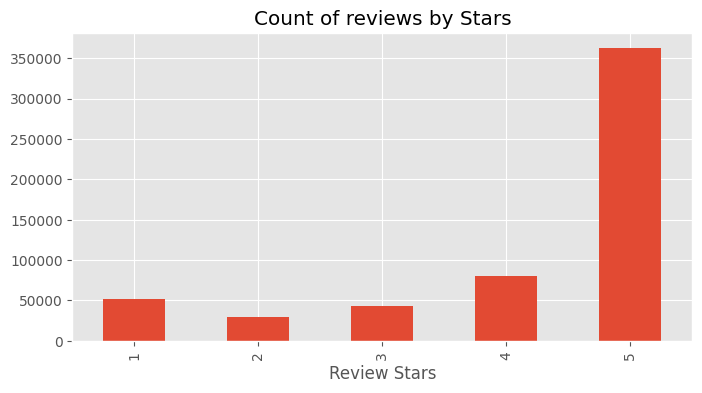

In [14]:
ax = df["Score"].value_counts().sort_index().plot(kind = "bar", title = "Count of reviews by Stars", figsize = (8, 4))
ax.set_xlabel("Review Stars")
plt.show()

In [15]:
example = df["Text"][50]
display(example)
tokens = nltk.word_tokenize(example)
tokens[:10]

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [16]:
# parts of speech:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [17]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## 1. VADER Sentiment Scoring:
### VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach:

In [18]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [19]:
sia.polarity_scores("I am so Happy")

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [20]:
sia.polarity_scores("This is worst thing")

{'neg': 0.577, 'neu': 0.423, 'pos': 0.0, 'compound': -0.6249}

In [21]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

### Run the Polarity Score on the Dataset:

In [27]:
df = df.sample(10000).copy(deep = True)

In [28]:
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row["Text"]
    myid = row["Id"]
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [31]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns = {"index":"Id"})
vaders = vaders.merge(df, how = "left")
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,366167,0.062,0.839,0.098,0.6536,B001D9JC0G,A1L194173Y170B,B. Davis,0,0,1,1242172800,"Was great, but formula changed!",My dog was on Canidae for almost 2 years and s...
1,69960,0.000,0.871,0.129,0.7133,B004HEJDYY,A3Q52B7U4RGX0O,Asha jones,0,0,5,1331596800,Great meat substitute,I recently used this faux meat in a beef and b...
2,44966,0.000,0.813,0.187,0.8716,B0029NTQ1K,A20XWDZHAXIYOK,J. Saoud,0,0,5,1311292800,My cats love Temptations,My cats loved these treats and I think that th...
3,9578,0.000,1.000,0.000,0.0000,B000V6FTT0,A3MGLZCFNQ64T,Evan Wilson,0,0,3,1328659200,Pasty noodle mash at the end of serving,Every time I heated this particular soup in an...
4,371613,0.184,0.705,0.111,-0.2933,B003AOIN4I,A3VF7QWKWT0PG6,"B. Klein ""Bruce""",0,0,2,1349395200,paragon sugar free wild cherry,I really didnt like the taste. I need somethin...


#### Plot VADER Results:

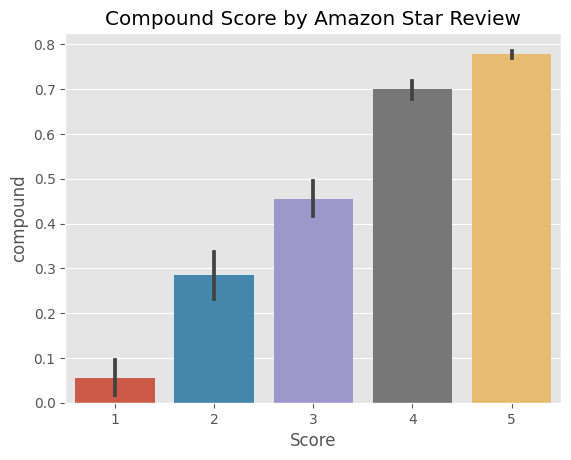

In [32]:
ax = sns.barplot(data = vaders, x= "Score", y = "compound")
ax.set_title("Compound Score by Amazon Star Review")
plt.show()

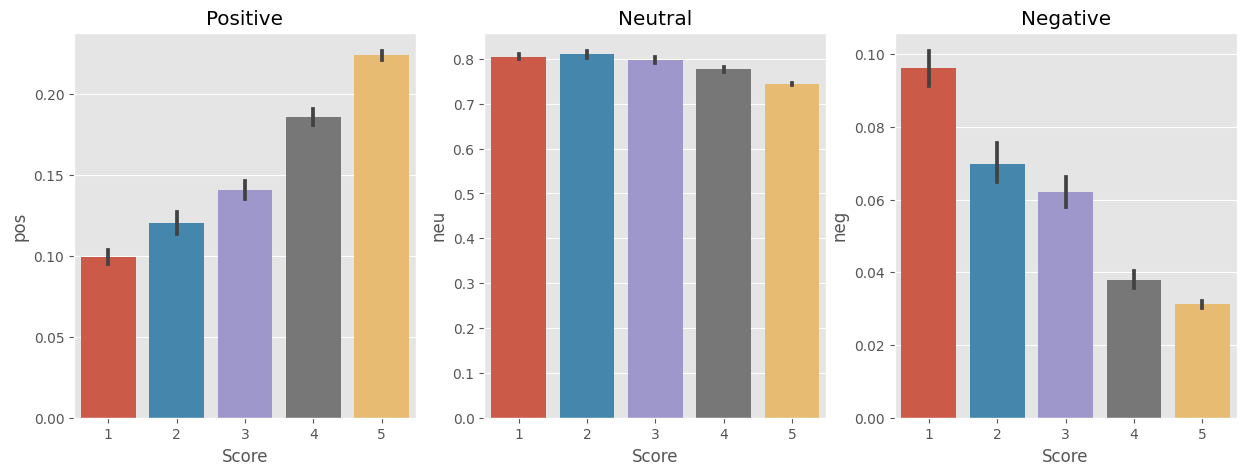

In [37]:
fg, axs = plt.subplots(1, 3, figsize = (15, 5))

sns.barplot(data = vaders, x = "Score", y = "pos", ax = axs[0])
sns.barplot(data = vaders, x = "Score", y = "neu", ax = axs[1])
sns.barplot(data = vaders, x = "Score", y = "neg", ax = axs[2])

axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")

plt.show()

## Roberta Pretrained Model:

In [40]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax 

In [41]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly 

In [43]:
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [47]:
encoded_text = tokenizer(example, return_tensors = "pt")
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

scores_dict = {"Roberta Pos": scores[0], 
              "Roberta neu": scores[1], 
              "Roberta Neg": scores[2]}
print(scores_dict)

{'Roberta Pos': 0.9535124, 'Roberta neu': 0.040926374, 'Roberta Neg': 0.0055612465}


In [48]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors = "pt")
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    scores_dict = {"Roberta Pos": scores[0], 
              "Roberta neu": scores[1], 
              "Roberta Neg": scores[2]}
    return scores_dict
    

In [54]:
df = df.sample(200).copy(deep = True)

In [55]:
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    try:
        text = row["Text"]
        myid = row["Id"]
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f"Broke for Id {myid}")

  0%|          | 0/200 [00:00<?, ?it/s]

Broke for Id 304993
Broke for Id 90168
Broke for Id 354750
Broke for Id 437094
Broke for Id 155014
Broke for Id 153774
Broke for Id 494341


In [56]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns = {"index":"Id"})
results_df = results_df.merge(df, how = "left")

In [57]:
results_df.columns

Index(['Id', 'neg', 'neu', 'pos', 'compound', 'Roberta Pos', 'Roberta neu',
       'Roberta Neg', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

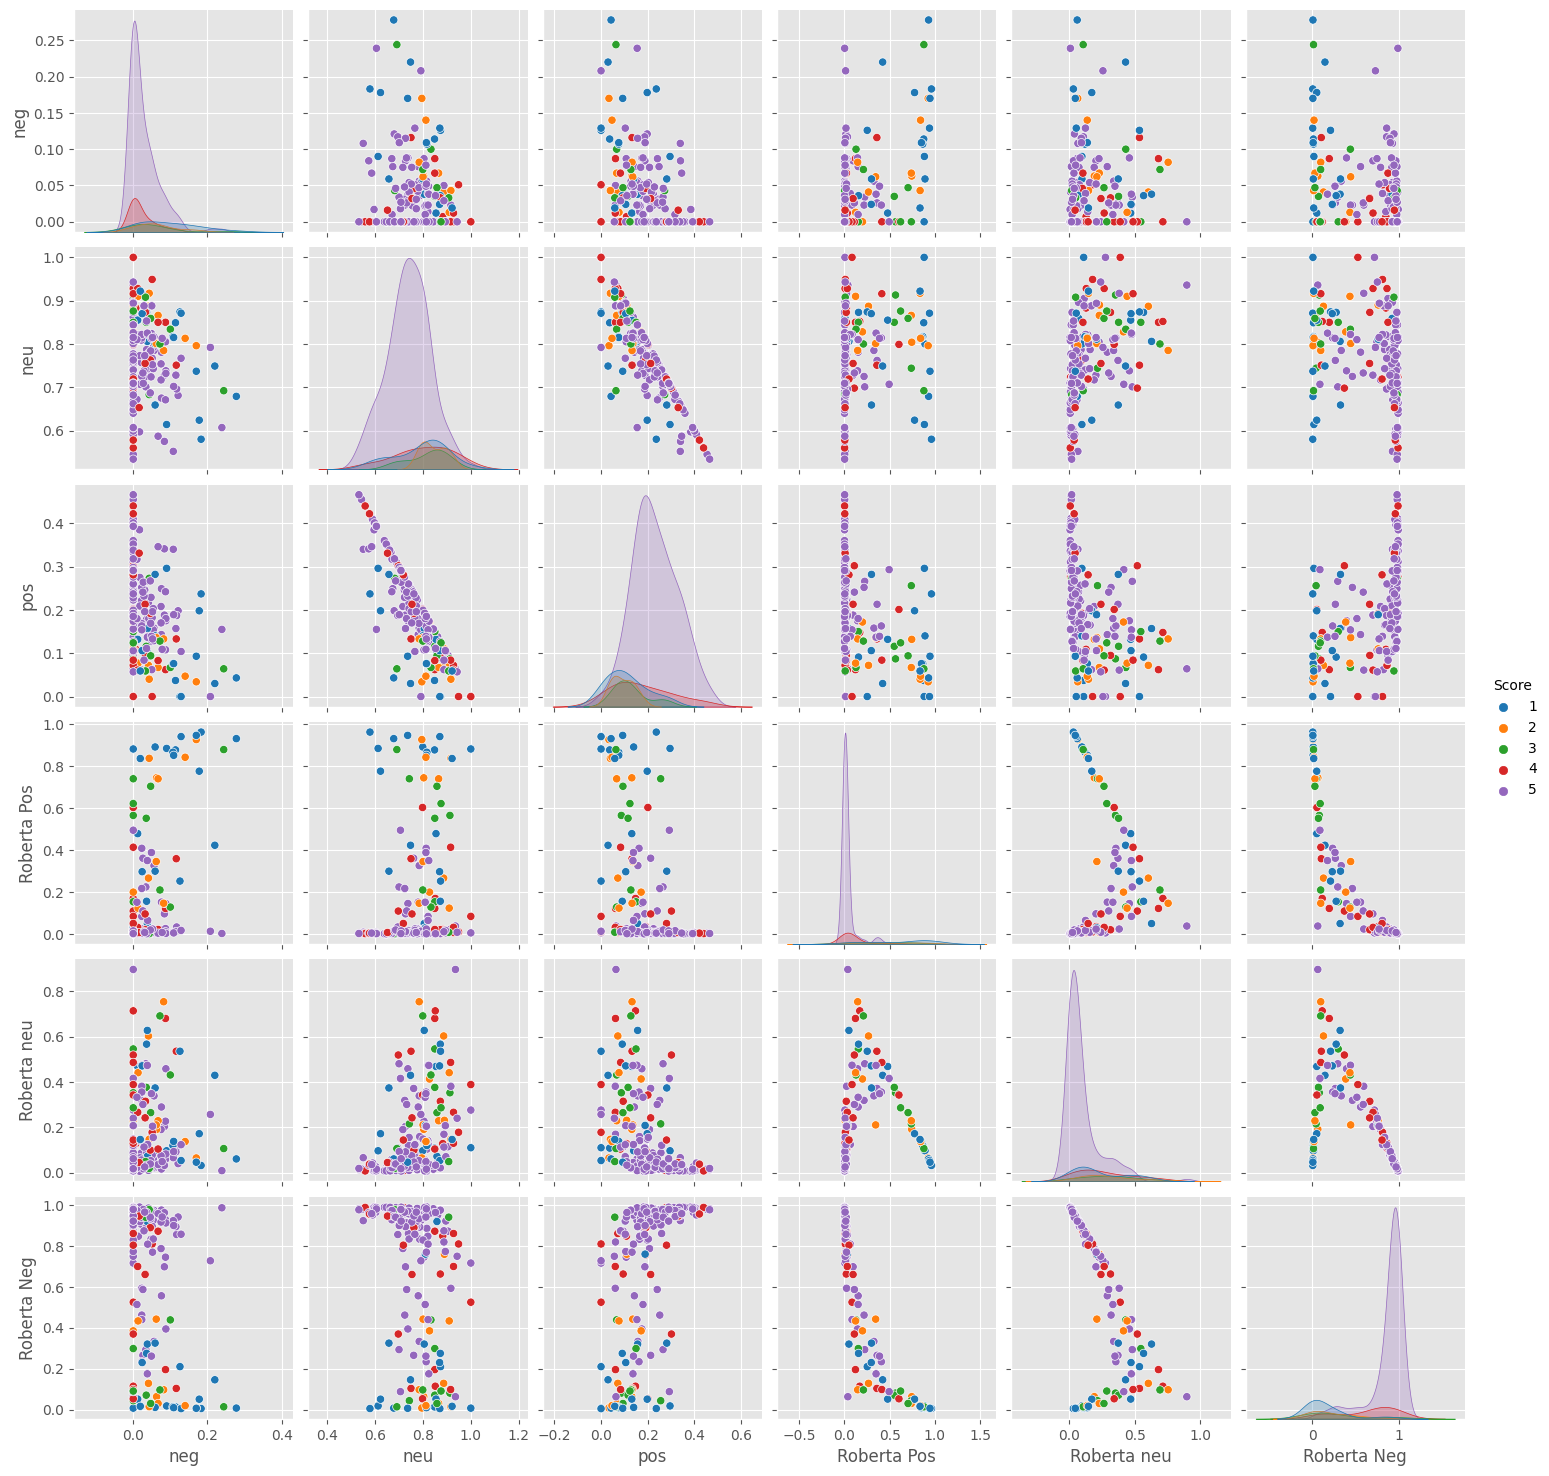

In [61]:
sns.pairplot(data = results_df, vars =['neg', 'neu', 'pos', 'Roberta Pos', 'Roberta neu',
       'Roberta Neg'],  hue = "Score", palette = "tab10")

plt.show()